# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Plan" data-toc-modified-id="Plan-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Plan</a></div><div class="lev2 toc-item"><a href="#Classes" data-toc-modified-id="Classes-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Classes</a></div><div class="lev2 toc-item"><a href="#Tests" data-toc-modified-id="Tests-03"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Tests</a></div>

## Plan
* Sit for 8 hours and finish it. Rest will happen automatically. 
* Function call flow:
* x -> x_down -> y_loc, y_class -> pred_loc, pred_class -> loss_class, loss_reg -> loss
* This completes the feedback loop.

## Classes
The following classes/methods exist in the dataset
* downsample
* encode
* Network
* Loss

In [1]:
import numpy as np
from network import VGGNet


def encode_y(x_down, labels_down):
    """
    x_downsampled tensor -> y_tensor: Numpy
    
    Args:
        x_down (b, 3, 60, 60): Downsampled list of images
        labels_down (b, v, 2): List of lists of lists (downsampled boxes)
        
    Returns:
        y_class (b, 1, 60, 60): Tensor containing mask for each image. Calculated within encode
        y_loc (b, 4, 60, 60):
    """
    
    y_class = np.zeros((x_down.shape[0], x_down.shape[2], x_down.shape[3]))
    y_loc = np.zeros((x_down.shape[0], 4, x_down.shape[2], x_down.shape[3]))
    
    y_class[x_down[:,0,:,:]>0] = 1 # Can also choose a smaller neighbourhood here
    pos_inds = np.argwhere(y_class) # y_class is also the positive examples mask
    
    for b, y, x in pos_inds:
        y_loc[b, :, y, x] = match_boxes(x, y, labels_down[b])
        
    y_class = y_class.reshape(x_down.shape[0], 1, x_down.shape[2], x_down.shape[3])
    
    return y_class, y_loc

def match_boxes(x, y, boxes):
    """ Numpy
    Matches a point (x,y) to a bunch of boxes. Returns offset of the box with the nearest centre.
    
    Args:
        x (scalar): X coordinate of point being matched
        y (scalar): Y coordinate of point being matched
        boxes: List of list of downsampled boxes being matched, in (tx, ty, bx, by) notation
    
    """
    
    dist = 10**5 # Store the smallest disance to a large no initially, can glitch if dist greater than this
    
    for box in boxes:
        cx = (box[0] + box[2])/2
        cy = (box[1] + box[3])/2
        
        box_dist = (cx - x)**2 + (cy - y)**2
        
        if box_dist < dist:
            offset = np.array([box[0] - x, box[1] - y, box[2] - x, box[3] - y])
            dist = box_dist
            
    # Should not glitch because matching is only done for positive indices
    return offset
    

def downsample(x):
    """
    x -> x/4
    
    Args:
        x (b, 3, 240, 240): Batch of 3 channel 240 x 240 images

    Returns:
        x_down (b, 3, 60, 60): Batch of 3 channel 60x60 images
    """
    db = SquaresDataset()
    imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
    
    print('images shape', imgs.shape)

    first_down = F.max_pooling_2d(imgs, 2, stride=2 )
    second_down = F.max_pooling_2d(first_down, 2, stride=2 )
    
    return second_down   
    
    
    pass

def labels_downsample(images): 
    pos_list = []
    imgs = images
    first_down = F.max_pooling_2d(imgs, 2, stride=2 )
    second_down = F.max_pooling_2d(first_down, 2, stride=2 )
    
    for i, image in enumerate(second_down): 
      
        original_image =imgs[i,:,:,:]
        original_image =np.transpose(original_image)

        # get the ones in the image
        posx,posy,_=np.divide((np.where(original_image ==1)),4).astype(int)                    
        pos_list.append([posx,posy]) 

    return pos_list

def loss(pred_class, pred_loc, gt_class, gt_loc, lambd=0.4):
    """
    Calculates weighted sum of classification and regression loss. Calls the classification loss and regression loss functions separately.
    
    Args:
        pred_class (b, 1, 60, 60): Network confidence probs for images
        pred_loc (b, 4, 60, 60): Network offsets for each location
        gt_class (b, 1, 60, 60): Gt class scores from encode
        gt_loc (b, 4, 60, 60): Gt regression offsets from encode
        lambd (scalar): WEighting factor comparison regression loss to 
        
    Returns:
        loss: Scalar value of 
    """
    return classification_loss(pred_class, gt_class) + lambd * regression_loss(pred_loc, gt_loc, gt_class)

def classification_loss(pred_class, gt_class):
    """
    Classification loss from mean squared diff between probabilities. Should probably use cross entropy instead but usng this now for simplicity.
    
    Also does hard negative mining. so requires generation of a selction mask of positives and most overconfident negatives.
    
    Args:
        pred_class (b, 1, 60, 60): Network confidence probs
        gt_class (b, 1, 60, 60): Binary gt confidence probs
        
    Returns:
        class_loss: Scalar
    """
    abs_loss = (pred_class - gt_class) ** 2
    mask = selection_mask(abs_loss, gt_class)
    selected_loss = abs_loss * mask
    
    return selected_loss.sum()/pred_class.shape[0]

def regression_loss(pred_loc, gt_loc, gt_class):
    """
    Regression loss from vanilla mean squared diff between shifts.
    
    Args:
        pred_loc (b, 4, 60, 60): Network offsets for top left and bottom right of box. Should 
        gt_loc (b, 4, 60, 60): Ground truth offsets for top left and bottom right of box.  
        gt_class (b, 1, 60, 60): Offsets for positive examples
        
    Returns:
        reg_loss: Scalar
    """
    abs_loss = ((pred_loc - gt_loc) ** 2).sum(axis=1) # Check dims in test
    selected_loss = abs_loss * gt_class
    
    return selected_loss.sum()/pred_loc.shape[0]

def selection_mask(abs_loss, gt_class):
    """
    Returns a binary mask from absolute mean square classification loss and the ground truth mask
    
    Args:
        abs_loss (b, 1, 60, 60): Absolute probability loss value over each pixel
        gt_class (b, 1, 60, 60): Binary gt probs to set the positive pixels to one
        
    Returns;
        select_mask (b, 1, 60, 60): Selection mask for poth positive and negative pixels0
    """
    yinv = 1 - gt_class
    
    l_neg = yinv*abs_loss

    select_mask = np.zeros(gt_class.shape)

    for num,i in enumerate(l_neg):
        indices = np.argsort(i.data,axis=None )

        matrix_indices = np.unravel_index(indices,(3,3))
        matrix_indices_flipped = np.fliplr(matrix_indices)

        k_value= np.sum(gt_class[num,:,:])
       
        k_value = int(k_value)

        matrix_indices_flipped = matrix_indices_flipped[:,0:k_value]

        select_mask[num,0,matrix_indices_flipped[0],matrix_indices_flipped[1]]= 1
        
        select_mask[num,0,:,:] =select_mask[num,0,:,:] + y_star[num,0,:,:]
        
    return select_mask 

# class DenseBoxes(Chain):
#     def __init__(self):
#         super(DenseBoxes, self).__init__(
#         # List of all the layers in denseboxes here.
#     )

## Tests
Writing tests for all of these methods. Checking all of them should be sufficient for this code.

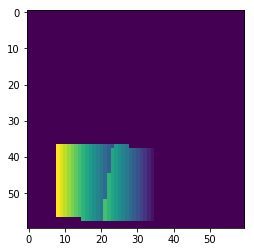

.

images shape (2, 3, 240, 240)
(3, 60, 60)


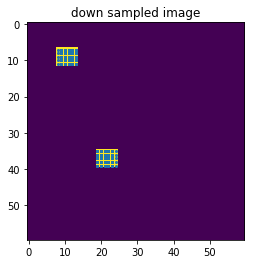

(3, 60, 60)


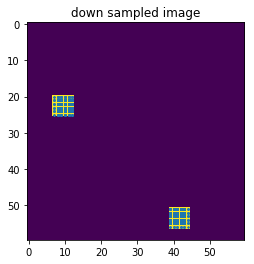

..

 pred_loc shape : (2, 4, 60, 60)
 pred_class shape : (2, 1, 60, 60)
images shape (2, 3, 240, 240)
xdown shape (2, 3, 60, 60)


.

abs loss shape (2, 60, 60)
total loss 107805.007854
images shape (2, 3, 240, 240)


.
----------------------------------------------------------------------
Ran 5 tests in 8.182s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [2]:
import unittest
from unittest import TestSuite
from dataset import SquaresDataset
import matplotlib.pyplot as plt
import chainer.functions as F

class TestCode(unittest.TestCase):
    
    def test_dataset(self):
        """ TESTED: Test that datast works """
        #print('lola')
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=60, img_w=60)
        db.visualize_batch(imgs, labels)
    
    def test_encode_y(self):
        """ TESTED: Manually worked out example with batch size of two. Trivial category. """
        # Visualizing should also be fine
        # Encoded boxes in a couple of boxes should look like the distance transform
        
        # Let's try with random values first
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=60, img_w=60)
        gt_class, gt_loc = encode_y(imgs, labels)
        
#         print(gt_class.shape, gt_loc.shape)

        plt.imshow(gt_loc[0,2,:,:])
#         print(gt_loc[0,0,:,:].min())
        plt.show()
        # Then we will visualize and check
        
        # Then we will think of a clever way to test
        
#         print('lola')
        
    def test_downsample(self):
        """ LOGIC: Test that shape matches. """
        # Visualizing should also be fine
        
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        print('images shape', imgs.shape)
#         db.visualize_batch(imgs, labels)
        
        first_down = F.max_pooling_2d(imgs, 2, stride=2 )
        second_down = F.max_pooling_2d(first_down, 2, stride=2 )
       
        pos_list = []
        for i, image in enumerate(second_down): 
            
            ax =plt.gca()          
            original_image =imgs[i,:,:,:]
            original_image =np.transpose(original_image)
           
            # get the ones in the image
            posx,posy,_=np.divide((np.where(original_image ==1)),4).astype(int)
                    
            # plot max pooled image with 
            print(image.shape)
            ax.scatter(posx, posy, s = 1)
            ax.imshow(image[0].data)
            
            plt.title('down sampled image')
            plt.show()
            pos_list.append(zip(posx,posy)) 
       
        pass
    
    def test_predict(self):
        """ LOGIC: What does this method do? """
        # Visualizing should also be fine
        
        pass
    
    def test_network(self):
        """ LOGIC: Test that the shape is correct? """
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        vgg = VGGNet()
        pred_loc, pred_class= vgg(imgs)
        print(' pred_loc shape :', pred_loc.shape)
        print(' pred_class shape :', pred_class.shape)
        
        pass
    
    def test_loss(self):
        """ LOGIC: Calculate sample loss for the network. Trivial category. """
        print(loss(pred_class, pred_loc, gt_class, gt_loc, lambd=0.4))
        pass
    
    def test_reg_loss(self):
        """ LOGIC: Calculate regression loss for the network with batch size of two. Trivial category. """
        # Should we show the regression loss hm here?
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        x_down = downsample(imgs)
        print('xdown shape', x_down.shape)
        pos_list= labels_downsample(imgs)
        gt_class, gt_loc= encode_y(x_down.data,pos_list)
        
        vgg = VGGNet()
        pred_loc, pred_class= vgg(imgs)
        abs_loss = ((pred_loc.data - gt_loc) ** 2).sum(axis=1)
        print('abs loss shape', abs_loss.shape)
        
        selected_loss = abs_loss * gt_class.data
        total_loss = selected_loss.sum()/pred_class.shape[0]
    
        print('total loss', total_loss)
    def test_class_loss(self):
        """ LOGIC: Calculate classification loss for the network with batch size of two. Trivial category. """
        # Should we show the classification loss heatmap here?
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        x_down = downsample(imgs)
        
        pos_list= labels_downsample(imgs)
        gt_class, gt_loc= encode_y(x_down.data,pos_list)
        
        vgg = VGGNet()
        pred_loc, pred_class= vgg(imgs)
    
        abs_loss = (pred_class - gt_class) ** 2
        mask = selection_mask(abs_loss, gt_class)
        selected_loss = abs_loss * mask
        
        pass
    
    def test_convergence(self):
        """ Check that for the one and two squares datasets, the network loss convergence. Plot the loss and show that it converges. """
        pass
    
    def test_select_mask(self):
        """ For controlled inputs, check what the mask looks like. Does it look sensible? """
        db = SquaresDataset()
        imgs, labels = db.generate_batch(n=2, h=20, w=20, img_h=240, img_w=240)
        x_down = downsample(imgs)
        
        pos_list= labels_downsample(imgs)
        gt_class, gt_loc= encode_y(x_down.data,pos_list)
        
        vgg = VGGNet()
        pred_loc, pred_class= vgg(imgs)
    
        abs_loss = (pred_class - gt_class) ** 2
        
        yinv = 1 - gt_class
        l_neg = yinv*abs_loss
        select_mask = np.zeros(gt_class.shape)
        
        
        pass
    
ts = TestSuite()
#ts.ad
ts.addTests([TestCode('test_encode_y'),
             TestCode('test_downsample'),TestCode('test_network'),
             TestCode('test_reg_loss'),TestCode('test_select_mask')  ])

unittest.TextTestRunner().run(ts)
#alltests = unittest.TestSuite([fast, slow])